##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from multiprocessing import Pool
from functools import partial
from sklearn import metrics

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats

from ipywidgets import FloatProgress, HTML
from IPython.display import display, clear_output
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass


def Test(params,X,y,YScaled,XScaled,pool):
    return(np.random.rand(params['K']))


def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
        if Scope == 'Full':
            Model = ['PPFD_Avg','AirTC_Avg','VPD','wind_speed',
                    'Temp','VWC','Sedge','Shrub','Grass','Upland',
                    'HR','DOY']
        if Scope == 'Test':
            Model = ['PPFD_Avg','VPD','wind_speed','VWC']
    if Site == 'FishIsland':
        BaseFactors = []
        if Scope == 'Full':
            Model=['H','AirTC_Avg','VPD','NR_Wm2_Avg','PPFD_Avg','Table_1','Delta_Table_1','VWC_2','Delta_VWC_2',
                   'Temp_2_5_1','Temp_5_1','Temp_15_1','Active_Layer_1','Total_Rain_mm_Tot','u*','wind_speed',
                    'North','East','air_pressure']
        if Scope == 'Test':
            Model=['H','AirTC_Avg','RH_Samp','VPD','NR_Wm2_Avg','PPFD_Avg','Table_1','Delta_Table_1',
            'VWC_2','VWC_1','Temp_2_5_1','Temp_5_1','Temp_15_1','Delta_Temp_1',
            'Active_Layer_1','u*','wind_speed','air_pressure']
    return(Model)

def Stats(mse,se,r2,j,params,i=0):
    df = pd.DataFrame(index = [str(j)+'_'+str(i)],
                      data={'Model':[params['Model']],'MSE':[mse],'Size':j,'Number':i,'HiddenNodes':params['N'],
                            'SE':[se],'r2':[r2],'Performance':0,'K':[params['K']]})
    return(df)

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))

Scope = 'Full'
# Scope = 'Test'
processes=3
    
cwd = os.getcwd()
Site='FishIsland'
# Site = 'Illisarvik'
alpha = .05

pd.set_option('max_colwidth',200)
def Display (tar,prog1=None,prog2=None,MdLs=None,MdL=None):
    clear_output()
    display(tar)
    if prog1!=None:
        display(prog1)
    if prog2!=None:
        display(prog2)
    if MdLs!=None:
        display(MdLs)
    if MdL!=None:
        display(MdL)
    
tar = HTML(
            value=" ",
            placeholder='Target: ',
            description='Target: ',
        )
kwt = HTML(
        value=str(0),
        placeholder='Quit Score: ',
        description='Quit Score: ',
        )

Using TensorFlow backend.


ImportError: cannot import name 'joblib' from 'sklearn.externals' (C:\Anaconda3\lib\site-packages\sklearn\externals\__init__.py)

# Model

In [170]:
# depth = 15
Time = time.time()
# FirstRun = True
# FirstRun = False
# kwit = 0
# Pthresh = 1
# stop = 1
AllRes={}
if __name__ == '__main__':
    for target in ['fco2','fch4']:
        AllRes[target]={}
        AllRes[target]['Results'] = {}
        AllRes[target]['Derivatives'] = {}
        AllRes[target]['X'] = {}
        AllRes[target]['Factors'] = []
        Rm = []
        Input=ModSelect(Scope,Site)
        start = len(Input)
        IpKey=np.arange(0,start)
        IpDict={'Factors':Input.copy(),'Key':IpKey}
        try:shutil.rmtree(cwd+'/'+Site+'/'+target+'/')
        except:pass
        os.mkdir(cwd+'/'+Site+'/'+target+'/')  
        tar.value=target
        prog2 = FloatProgress(min=0, max=100,description='Bootstrapping:')
        MdL = HTML(value=" ",placeholder='Testing: ',description='Testing: ')
        Display (tar,prog2=prog2,MdL=MdL)
        Continue = True
        first = 1
        num = 0
        while Continue == True:
            Time2 = time.time()
            j = len(Input)
            params = Dense.Params(Scope,target)
            params['Dpath'] = cwd+'/'+Site+'/'
            params['Spath'] = params['Dpath']+'Test/'+target+'/'+str(j)+'_'+str(num)+'/'
            try:os.mkdir(params['Spath'])
            except:pass
            params['Sname'] = 'Y_'
            params['Inputs'] = Input
            MdL.value='N = '+str(j)+':  '+str(params['Inputs'])
#             Display (tar,prog1,prog2,MdLs,MdL)
            params['Model'] = '+'.join(params['Inputs'])
            RST = RSTF.ReadStandardTimeFill(params,'AllData.csv')#,resample='2H')
            if target == 'ER':
                RST.Master = RST.Master.loc[RST.Master['fco2']>0]
            RST.Scale(params['target'],params['Inputs']) 
            y = RST.y*1.0
            X = RST.X*1.0
            Ni = len(Input)
            Ns = y.shape[0]
            No = 1
            a = 2
#             params['N']=int(Ns/(a*(Ni+No)))
            # Rule by Maier et al. 1998
            A = int(2*Ni+No)
            B = int(2*Ns/((Ni+No)))
            if A<B:params['N']=A
            else:params['N']=B
                
            params['Memory'] = (math.floor(100/params['proc'])- 5/params['proc']) * .01
            Y_hat=[]
            y_true=[]
            X_true=[]
            index=[]
            ones=[]
            prog2.value=0
            pool = Pool(processes=processes,maxtasksperchild=75)
            Avs = []
            Derivatives = []
            for k,results in enumerate(pool.imap(partial(Dense.Bootstrap,params=params,X=X,y=y),range(params['K']))):
                Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                y_true.append(RST.YScaled.inverse_transform(results[1]))
                X_true.append(RST.XScaled.inverse_transform(results[2]))
                ones.append(results[3])
                prog2.value=(k+1)/params['K']*100
                Avs.append(results[4])
                Derivatives.append(results[5])
            pool.close()
            Y_hat = np.squeeze(np.asanyarray(Y_hat))
            y_true = np.squeeze(np.asanyarray(y_true))
            X_true = np.asanyarray(X_true)
            ones = np.asanyarray(ones)
            params['Memory'] = .95
            pool = Pool(processes=1,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Sort_outputs,params=params,
             Y_hat=Y_hat,y_true=y_true,X_true=X_true,ones=ones),range(1))):
                 mse,se,r2 = results
            pool.close()
            Level = Stats(mse,se,r2,j,params,i=num)
            Level.to_csv('Temp.csv')
#             prog1.value=start-j#+i/len(Inputs)
            Level['Thresh'] = Level['MSE']+Level['SE']
            Min = Level.loc[Level['MSE']==Level['MSE'].min()]
            if first == 1:
                Records = Level
            else:
                Records = Records.append(Level)
            
            Av = np.array(Avs).mean(axis=0)
            Drv = np.array(Derivatives)#.mean(axis=0)
            SE = (np.array(Avs).T/np.array(Avs).sum(axis=1)).T
            SE = SE.std(axis=0)**.5/(params['K']**.5)
            if first==2:
                IpDict['RC: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])#Av/Av.sum()
                IpDict['SE: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])#Av/Av.sum()
            else:
                first = 2
            Results = pd.DataFrame(data=IpDict)
            for I,A,S in zip(Input,Av,SE):
                Results.loc[Results['Factors']==I,'RC: '+str(j)+'_'+ str(num)]=A
                Results.loc[Results['Factors']==I,'SE: '+str(j)+'_'+ str(num)]=S
            Results['RC: '+str(j)+'_'+ str(num)]=Results['RC: '+str(j)+'_'+ str(num)]/Results['RC: '+str(j)+'_'+ str(num)].sum()
            IpDict['RC: '+str(j)+'_'+ str(num)]=Results['RC: '+str(j)+'_'+ str(num)].values
            IpDict['SE: '+str(j)+'_'+ str(num)]=Results['SE: '+str(j)+'_'+ str(num)].values
            Results = Results.sort_values('RC: '+str(j)+'_'+ str(num))
            
            Rm.append(Results.Factors.values[num])
            print(Rm,Results.Factors.values[num])
            Input.remove(Rm[-1])
            Results = Results.sort_values('Key')
            Min = Records.loc[Records['MSE']==Records['MSE'].min()]
            if Min['MSE'].values[0]+Min['SE'].values[0]<=Level['MSE'].values[0]:
#             if start - j > 3:
                Continue = False
            AllRes[target]['Records']=Records
            AllRes[target]['Results'] = Results
            AllRes[target]['Derivatives'][j]=Drv
            AllRes[target]['X'][j] = X_true[0]
            AllRes[target]['Factors'].append(j)
            AllRes[target]['Removed']=Rm
            Records.to_csv('C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'+target+'_Test.csv')
            num +=1
            print('Total Runtime: ',time.time()-Time)
            print('Training Time: ', time.time()-Time2)
#             j+=1

HTML(value='fch4', description='Target: ', placeholder='Target: ')

FloatProgress(value=0.0, description='Bootstrapping:')

HTML(value=' ', description='Testing: ', placeholder='Testing: ')

['VPD'] VPD
Total Runtime:  2258.462501525879
Training Time:  157.81731009483337
['VPD', 'North'] North
Total Runtime:  2398.700448036194
Training Time:  140.23894619941711
['VPD', 'North', 'East'] East
Total Runtime:  2530.0874469280243
Training Time:  131.3869981765747
['VPD', 'North', 'East', 'AirTC_Avg'] AirTC_Avg
Total Runtime:  2659.7019503116608
Training Time:  129.61450242996216
['VPD', 'North', 'East', 'AirTC_Avg', 'PPFD_Avg'] PPFD_Avg
Total Runtime:  2801.4349133968353
Training Time:  141.73196506500244
['VPD', 'North', 'East', 'AirTC_Avg', 'PPFD_Avg', 'NR_Wm2_Avg'] NR_Wm2_Avg
Total Runtime:  2927.531034231186
Training Time:  126.09711837768555
['VPD', 'North', 'East', 'AirTC_Avg', 'PPFD_Avg', 'NR_Wm2_Avg', 'Temp_15_1'] Temp_15_1
Total Runtime:  3064.153583049774
Training Time:  136.62254810333252
['VPD', 'North', 'East', 'AirTC_Avg', 'PPFD_Avg', 'NR_Wm2_Avg', 'Temp_15_1', 'Delta_VWC_2'] Delta_VWC_2
Total Runtime:  3194.407385110855
Training Time:  130.25280570983887
['VPD', 

In [183]:
F = 'fco2'
print(AllRes[F]['Factors'])
print(AllRes[F]['Results'])
print(AllRes[F]['Records'])#-AllRes['fch4']['Results'][N]['RC: 18'])#.keys())
# Records = AllRes[F][N]['Records']

[19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7]
              Factors  Key  RC: 19_0  SE: 19_0  RC: 18_1  SE: 18_1  RC: 17_2  \
0                   H    0  0.088815  0.059637  0.065000  0.057237  0.081333   
1           AirTC_Avg    1  0.011940  0.026109  0.011572  0.027233  0.007835   
2                 VPD    2  0.078431  0.057696  0.072744  0.054609  0.086934   
3          NR_Wm2_Avg    3  0.015716  0.027206  0.011320  0.022148  0.016460   
4            PPFD_Avg    4  0.344748  0.083576  0.419733  0.088547  0.418422   
5             Table_1    5  0.014547  0.029076  0.012788  0.022298  0.019131   
6       Delta_Table_1    6  0.010792  0.031262  0.010284  0.028462  0.013568   
7               VWC_2    7  0.035076  0.044692  0.028575  0.036316  0.026416   
8         Delta_VWC_2    8  0.006969  0.026389  0.005775  0.032721  0.007077   
9          Temp_2_5_1    9  0.072700  0.049293  0.066028  0.052390  0.056110   
10           Temp_5_1   10  0.080433  0.048109  0.074903  0.051143  0.

19
(15, 8, 2438)


<IPython.core.display.Javascript object>


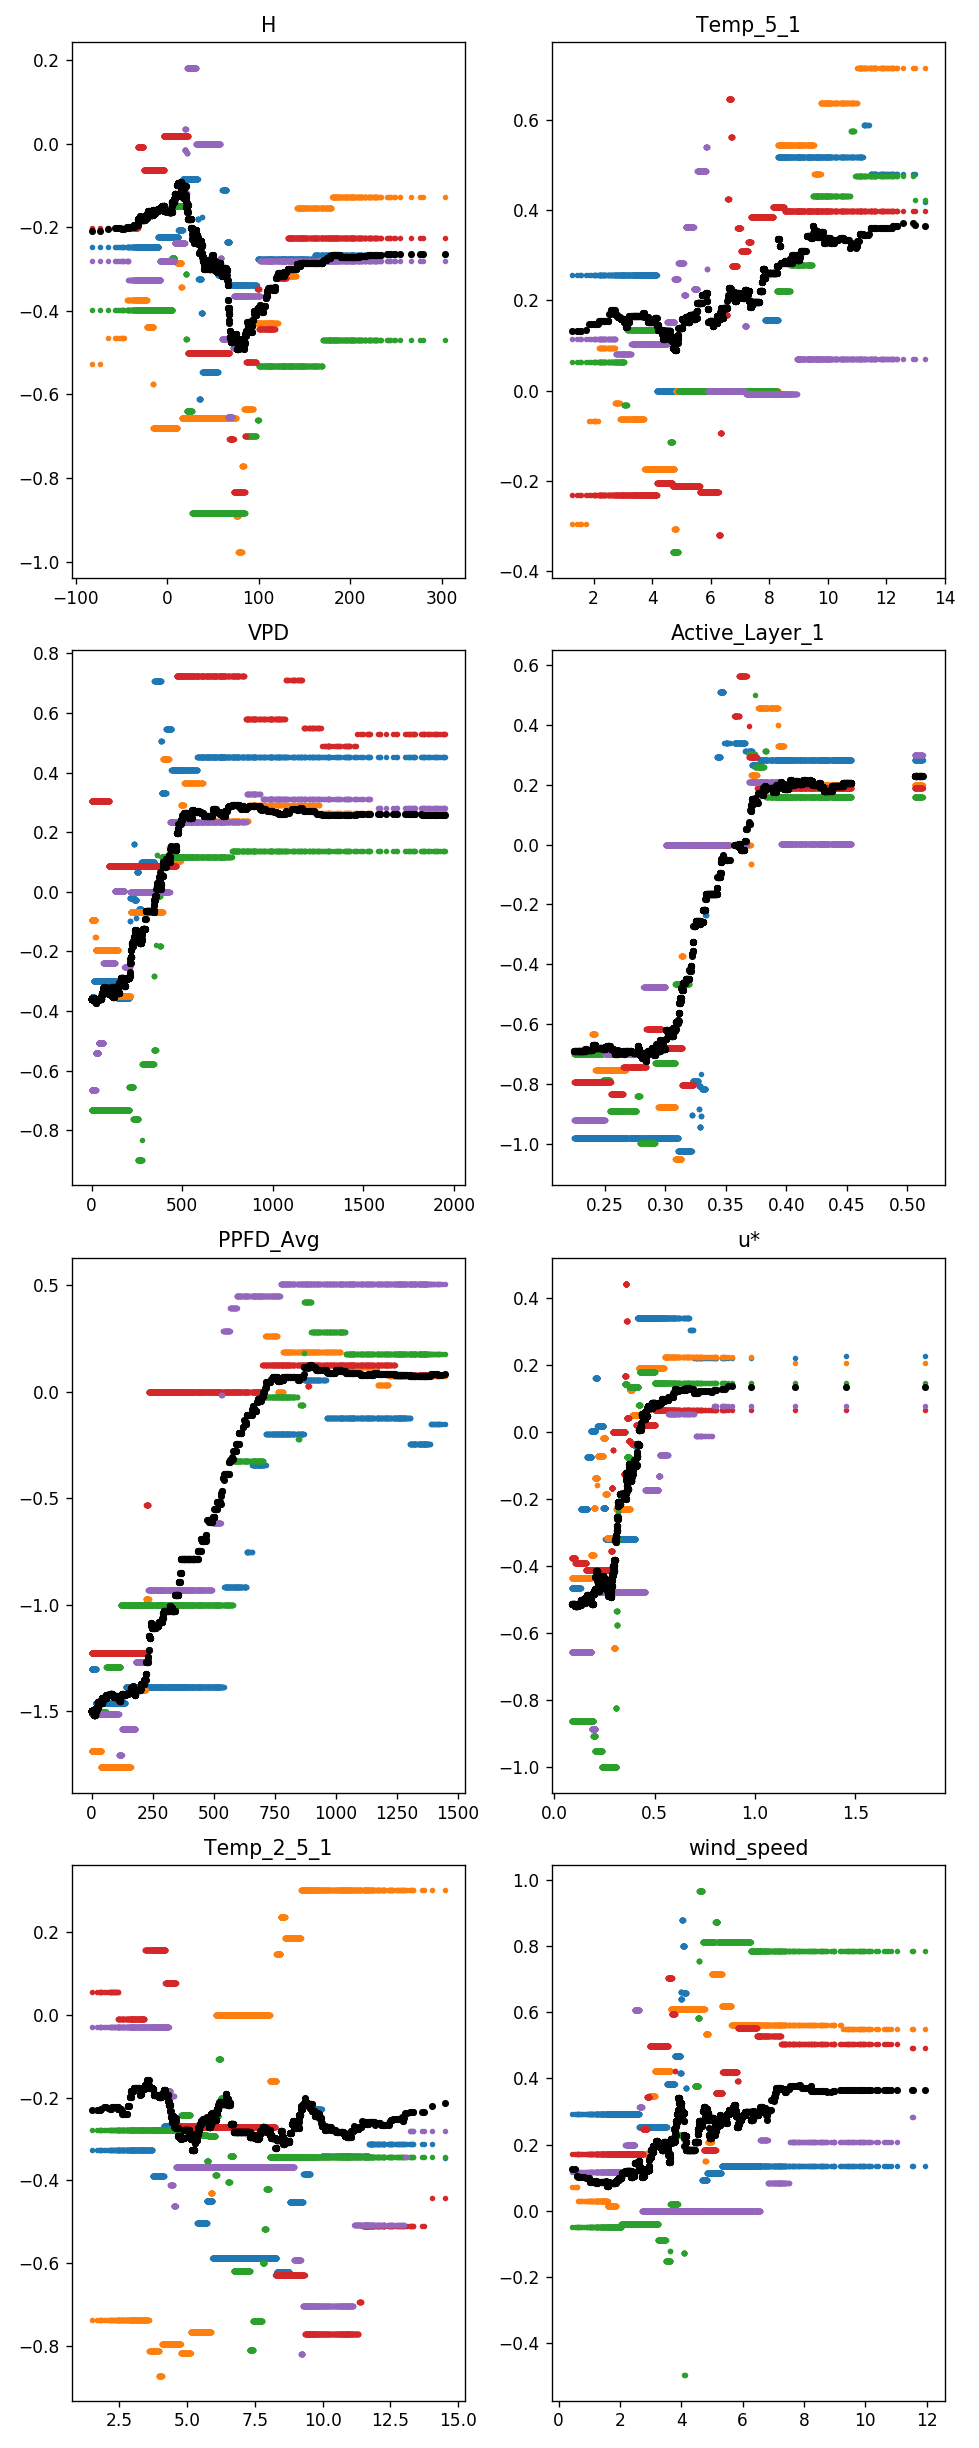

In [184]:

N = 8
print(len(Results.Factors.values))
Results = AllRes[F]['Results']
Derivatives = AllRes[F]['Derivatives'][N]
# Mean = Derivatives.mean(axis=0)
print(Derivatives.shape)
X = AllRes[F]['X'][N]


fig,ax = plt.subplots(int((N+1)/2),2,figsize = (8,20))
k = 0
j=0
TD = []
i = 0
for f,r in zip(Results.Factors.values,Results['RC: 8_11'].values):
#     print(f,r)
    if r > 0:
        if i >N/2-1:
            j=1
            k = (math.floor(N/2))
        for p in range(5):
            ax[i-k,j].scatter(X[:,i],Derivatives[p][i],s=5)
        ax[i-k,j].scatter(X[:,i],Mean[i],color='k',s=10)
        ax[i-k,j].set_title(f)
        TD.append([f,Mean[i].min(),Mean[i].max(),Mean[i].mean(),Mean[i].max()-Mean[i].min()])
        i +=1
plt.tight_layout()
Statistics = pd.DataFrame(data=TD,columns=['Factor','Min','Max','Mean','Range'])

# print(Statistics.sort_values('Range'))

In [174]:
print(Statistics.sort_values('Range'))

               Factor       Min       Max      Mean     Range
6       Delta_Table_1 -0.314249 -0.222143 -0.287677  0.092105
9          Temp_2_5_1  0.110128  0.310384  0.221310  0.200256
3          NR_Wm2_Avg -0.019795  0.203998  0.101018  0.223793
10           Temp_5_1 -0.249790 -0.012441 -0.123219  0.237349
17               East -0.213528  0.040570 -0.078010  0.254098
15         wind_speed -0.681344 -0.416518 -0.540991  0.264826
2                 VPD -0.261205  0.016218 -0.098102  0.277423
7               VWC_2 -0.385091 -0.107524 -0.264719  0.277567
13  Total_Rain_mm_Tot  0.027393  0.325684  0.059853  0.298291
0                   H  0.151352  0.456063  0.272901  0.304711
4            PPFD_Avg -0.207156  0.179223 -0.048502  0.386379
14                 u*  0.507743  0.920712  0.700261  0.412969
12     Active_Layer_1 -0.304557  0.115536 -0.058905  0.420093
1           AirTC_Avg -0.208050  0.215800 -0.000084  0.423850
11          Temp_15_1 -0.382265  0.063684 -0.155136  0.445949
16      

<IPython.core.display.Javascript object>


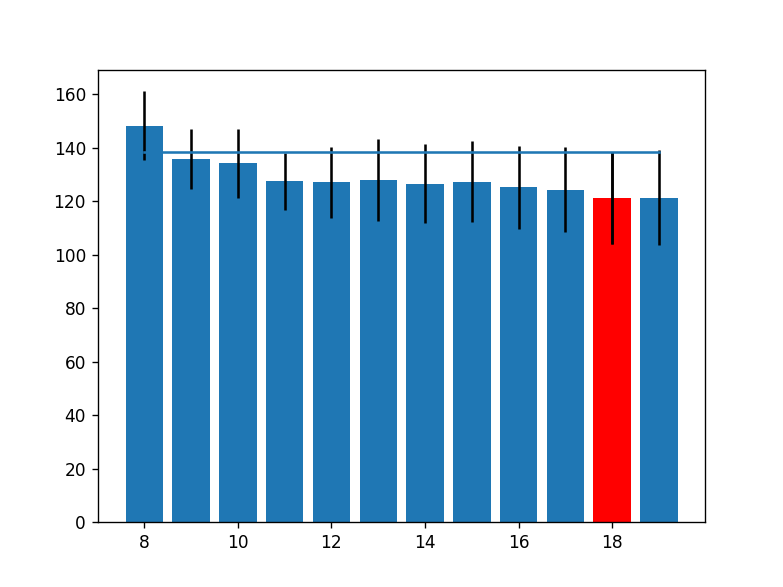

<IPython.core.display.Javascript object>


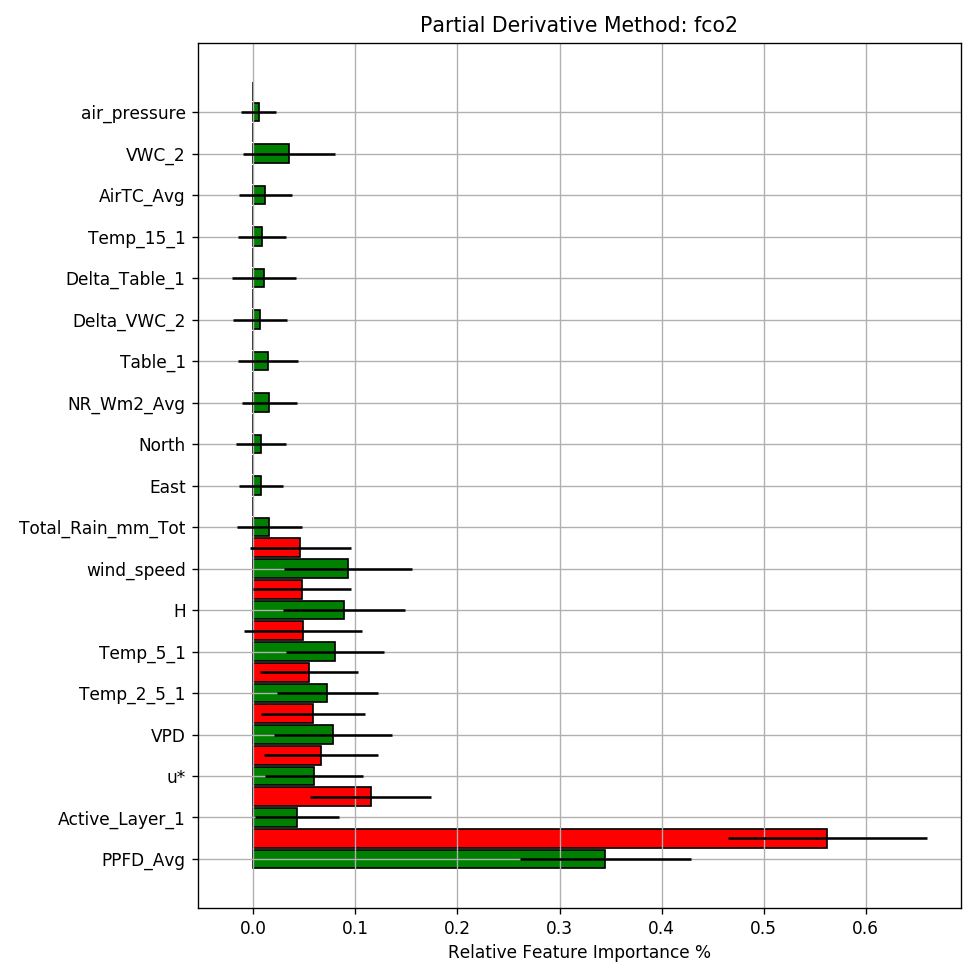

In [186]:

# print(Records)
a = '19_0'
b = '8_11'
Results = Results.sort_values('RC: '+b,ascending=False).reset_index()

plt.figure()
Min = Records.loc[Records['MSE']==Records['MSE'].min()]
plt.bar(Records['Size'],Records['MSE'],yerr=Records['SE'])
plt.bar(Min['Size'],Min['MSE'],yerr=Min['SE'],color='r')
line = [Min['MSE'].values[0]+Min['SE'].values[0],Min['MSE'].values[0]+Min['SE'].values[0]]
plt.plot([Records['Size'].min(),Records['Size'].max()],line)


# print(Rm)
# print(Results['SE: 20'])
# print(Results.Factors.values[1:])
fig,ax=plt.subplots(figsize=(8,8))
# Results.plot.barh(x='Key',y=['RC: 15'],ax=ax,width=.5,edgecolor='k',yerr=['SE: 15'])
plt.barh(Results.index,Results['RC: '+a],xerr=Results['SE: '+a],
         height=.45,color='g',edgecolor='k')
plt.barh(Results.index+.5,Results['RC: '+b],xerr=Results['SE: '+b],
         height=.45,color='r',edgecolor='k')
# plt.barh(Results.index+.5,Results['RC: '+Min],xerr=Results['SE: '+Min],height=.5,color='r')
# Results.plot.barh(x='Key',y=['RC: 19','RC: 20'],ax=ax,width=.5,edgecolor='k',yerr=['SE: 19','SE: 20'])
#                   y=['RC: '+str(x)for x in range(9,21)],ax=ax,width=.5)
ax.set_yticks(Results.index)
ax.set_yticklabels(Results['Factors'].values)
# plt.xticks(rotation=90)

ax.set_xlabel('Relative Feature Importance %')
ax.set_title('Partial Derivative Method: '+F)
ax.grid()
plt.tight_layout()
# plt.show()

plt.savefig('PAD_'+F+'_PrunedFactors.png')
# print(Results.shape[0])

